# RF microstrip: quarter wave stub filter

## Overview
We simulate a quarter wave stub bandstop filter in RF microstrip with nominal 5GHz notch. 

## Geometry

running luminescent python frontenda


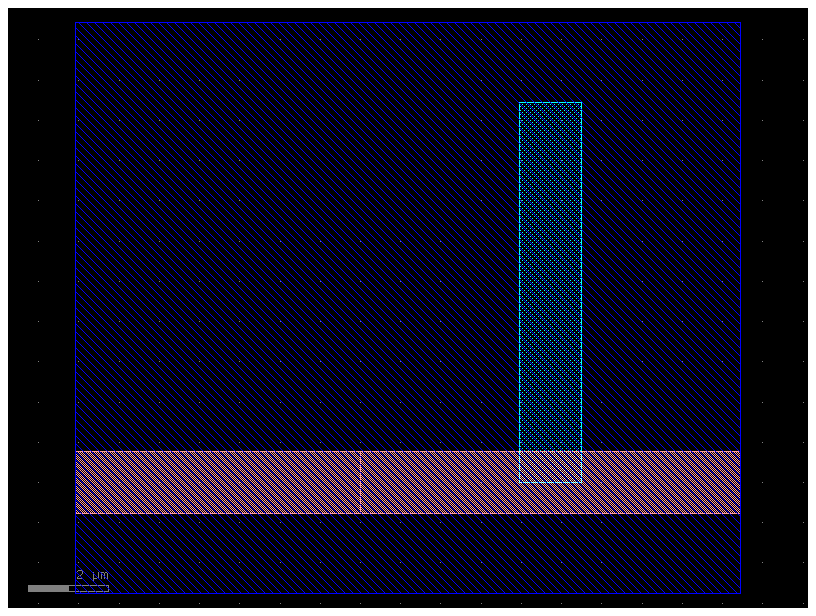

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os

# simulation folder 
study='microstrip_stub_filter'
path = os.path.join('studies', study)

# length and frequency units are arbitrary but must be consistent. here we use mm and GHz
frequency = 5  # characteristic frequency in GHz
frequencies = np.linspace(3, 7, 81).tolist()
wl1f = 300  # vacuum wavelength at 1 unit of frequency, all in your units
wavelength = wl1f / frequency  # characteristic wavelength
bandwidth = max(frequencies) - min(frequencies)

# microstrip
w_line = 1.52  # mm
th = 0.035  # mm
d = 0.8  # mm
c = 87.5 / 139  # relative signal speed, from microstrip calculator

wl_sig = wl1f * c / frequency  # wavelength in the signal line
l_stub = wl_sig / 4 # quarter-wave stub length
l_feed = 1 * l_stub
lateral_port_margin = height_port_margin = 2 * d
margin = zmargin = 1.25 * lateral_port_margin
lx_mode = w_line + 2 * lateral_port_margin  # lateral size of mode region
source_port_margin = 1.5 * (w_line + 2 * lateral_port_margin)

# layers
FEED = 1, 0
STUB = 2, 0
SUB = 10, 0

# make geometry in gdsfadory
# alternatively can import .gds into gdsfadory
c = gf.Component()
feed = c << lumi.straight(length=l_feed, width=w_line, layer=FEED)
stub = c << lumi.straight(length=l_stub, width=w_line, layer=STUB)
stub.rotate(90)
stub.movex(l_feed / 2)
ext = c << lumi.straight(source_port_margin, width=w_line, layer=FEED)
ext.connect("o2", feed.ports["o1"])

for i in (1, 2):
    c.add_port(f"o{i}", port=feed.ports[f"o{i}"])

c << gf.components.bbox(component=c, layer=SUB, top=margin, bottom=margin)
c.plot()

## Solve

saving mode plots to /home/weihu/lumi/luminescent/studies/microstrip_stub_filter/modes/1
showing modes for first wavelength 
solving modes with PEC boundaries
Solving port modes with FEM...


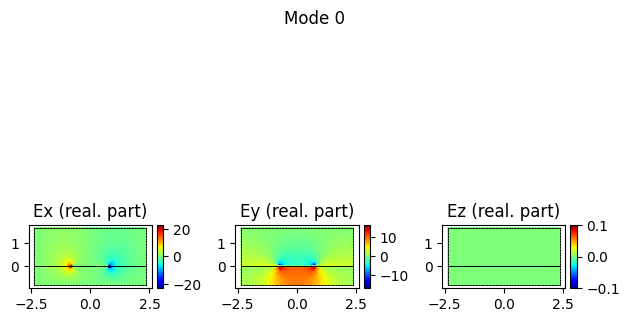

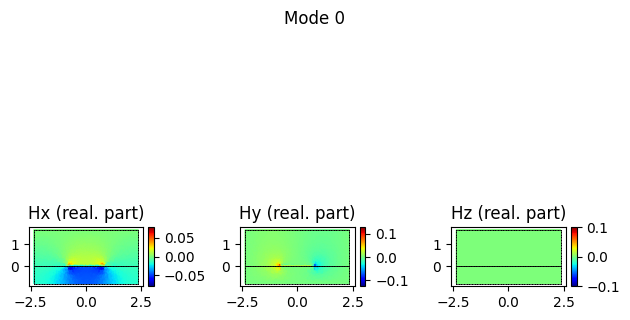

/home/weihu/.local/lib/python3.12/site-packages/skfem/assembly/form/linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)
/home/weihu/lumi/luminescent/luminescent/utils.py:655: ComplexWarning: Casting complex values to real discards the imaginary part
  E = np.array(
/home/weihu/lumi/luminescent/luminescent/utils.py:668: ComplexWarning: Casting complex values to real discards the imaginary part
  H = np.array(


using simulation folder /home/weihu/lumi/luminescent/studies/microstrip_stub_filter
0.19
Loading mesh from: /home/weihu/lumi/luminescent/studies/microstrip_stub_filter/geometry/1____PEC____feed____unnamed11.obj
0.19
Loading mesh from: /home/weihu/lumi/luminescent/studies/microstrip_stub_filter/geometry/2____PEC____feed____unnamed21.obj
0.19
Loading mesh from: /home/weihu/lumi/luminescent/studies/microstrip_stub_filter/geometry/3____PEC____stub____unnamed31.obj
0.9042052915695228
Loading mesh from: /home/weihu/lumi/luminescent/studies/microstrip_stub_filter/geometry/4____sub____core____unnamed41.obj


In [ ]:
# adaptive meshing
nres = 16
dx0 = wavelength / nres

layer_stack = LayerStack(
    layers={
        "feed": LayerLevel(
            layer=LogicalLayer(layer=FEED),
            zmin=0,
            thickness=th,
            material="PEC",
            mesh_order=10,
        ),
        "stub": LayerLevel(
            layer=LogicalLayer(layer=STUB),
            zmin=0,
            thickness=th,
            material="PEC",
            mesh_order=20,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=SUB),
            zmin=-d,
            thickness=d,
            material="sub",
            mesh_order=30,
        ),
    }
)

# materials
eps_sub = 4.3
n_sub = np.sqrt(eps_sub)

dx = w_line / 4  # 4 mesh points across the strip
n_PEC = dx0 / (dx)  # mesh density relative to vacuum

material_library = {
    "sub": lumi.Material(epsilon=eps_sub),
    "PEC": lumi.PECMaterial(mesh_density=n_PEC),
}
material_library["background"] = lumi.Material(epsilon=1.0)

_dx=dx 
_dy=th
modes = [
    lumi.Mode(
        ports=["o1", "o2"],
        frequencies=[frequency],
        metallic_boundaries=["y-", "feed"],
        nmodes=1,
        start=[-lx_mode/2, -d], # local xy frame, local y=0 at global zmin of port layer
        stop=[lx_mode/2, th + height_port_margin],
        voltage_line=[(0, -d), (0, 0)], # optional
        current_loop=[
            (-w_line / 2 - _dx,  - _dy),
            (-w_line / 2 - _dx,  th + _dy),
            (w_line / 2 + _dx,  th + _dy),
            (w_line / 2 + _dx,  - _dy),
        ], # optional
    )
]

sources = [
    lumi.Source(
        "o1", frequency=frequency, duration=0.5, source_port_margin=source_port_margin
    ) # modulated Gaussian pulse
]

views=[
        lumi.View("Ez", x=-source_port_margin, y=0, z=-d / 2),
        lumi.View("Hz", z=th / 2),
    ]
 
# Luminescent community cluster client
email=____# replace with your registered email
client=lumi.Client(email,cluster='luminescent_community_cluster')

lumi.make(
    path=path,
    component=c,
    frequency=frequency, # characteristic frequency
    frequencies=frequencies,
    wl1f=wl1f,
    sources=sources,
    modes=modes,
    # bounds
    boundaries=["PML", "PML", ["PEC", "PML"]],
    zmin=-d,
    zmax=th + zmargin,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    # performance
    nres=nres,
    relative_courant=0.9,  # relative courant number between 0 and 1
    relative_pml_depths=[1, 0.3, 0.3],
    energy_decay_threshold=0.01,  # field decay threshold for stopping simulation
    saveat=1,  # save frame for plotting every _ periods
    # visualization
    views=views,
    # 
    client=client,
)

In [ ]:
lumi.solve(path)

loading problem from /home/weihu/luminescent_community_cluster/paul@luminescentai.com/microstrip_stub_filter
Status Code: 200
authentication successful
max run time per job is 15 minutes
job queued. aborting this python client also aborts the job in the cluster jobs ...

loading simulation folder /home/weihu/luminescent_community_cluster/paul@luminescentai.com/microstrip_stub_filter ...

CPU:
	threads: 48

GPU 0: NVIDIA RTX PRO 6000 Blackwell Server Edition
	CUDA Compute Capability: 12.0.0
	VRAM: 94.97076416015625 GB

setting up simulation...

meshing geometry
making sources...
making monitors...
making designs...

simulation config

backend: GPU
float: Float32

original size: (46, 36, 17)
padded size: (91, 50, 24)
cell count: 109,200

relative Courant number: 0.9
step size: 1936.0 steps/period
source duration: 0.50 periods
max time: 1,000.50 periods    
energy decay threshold: 0.01

running simulation...

accumulating dft fields...
period 0.00, Inf seconds/period
period 0.25, 7.29 sec

## Visualize

Video generated successfully at /home/weihu/luminescent_community_cluster/paul@luminescentai.com/microstrip_stub_filter/simulation.gif!


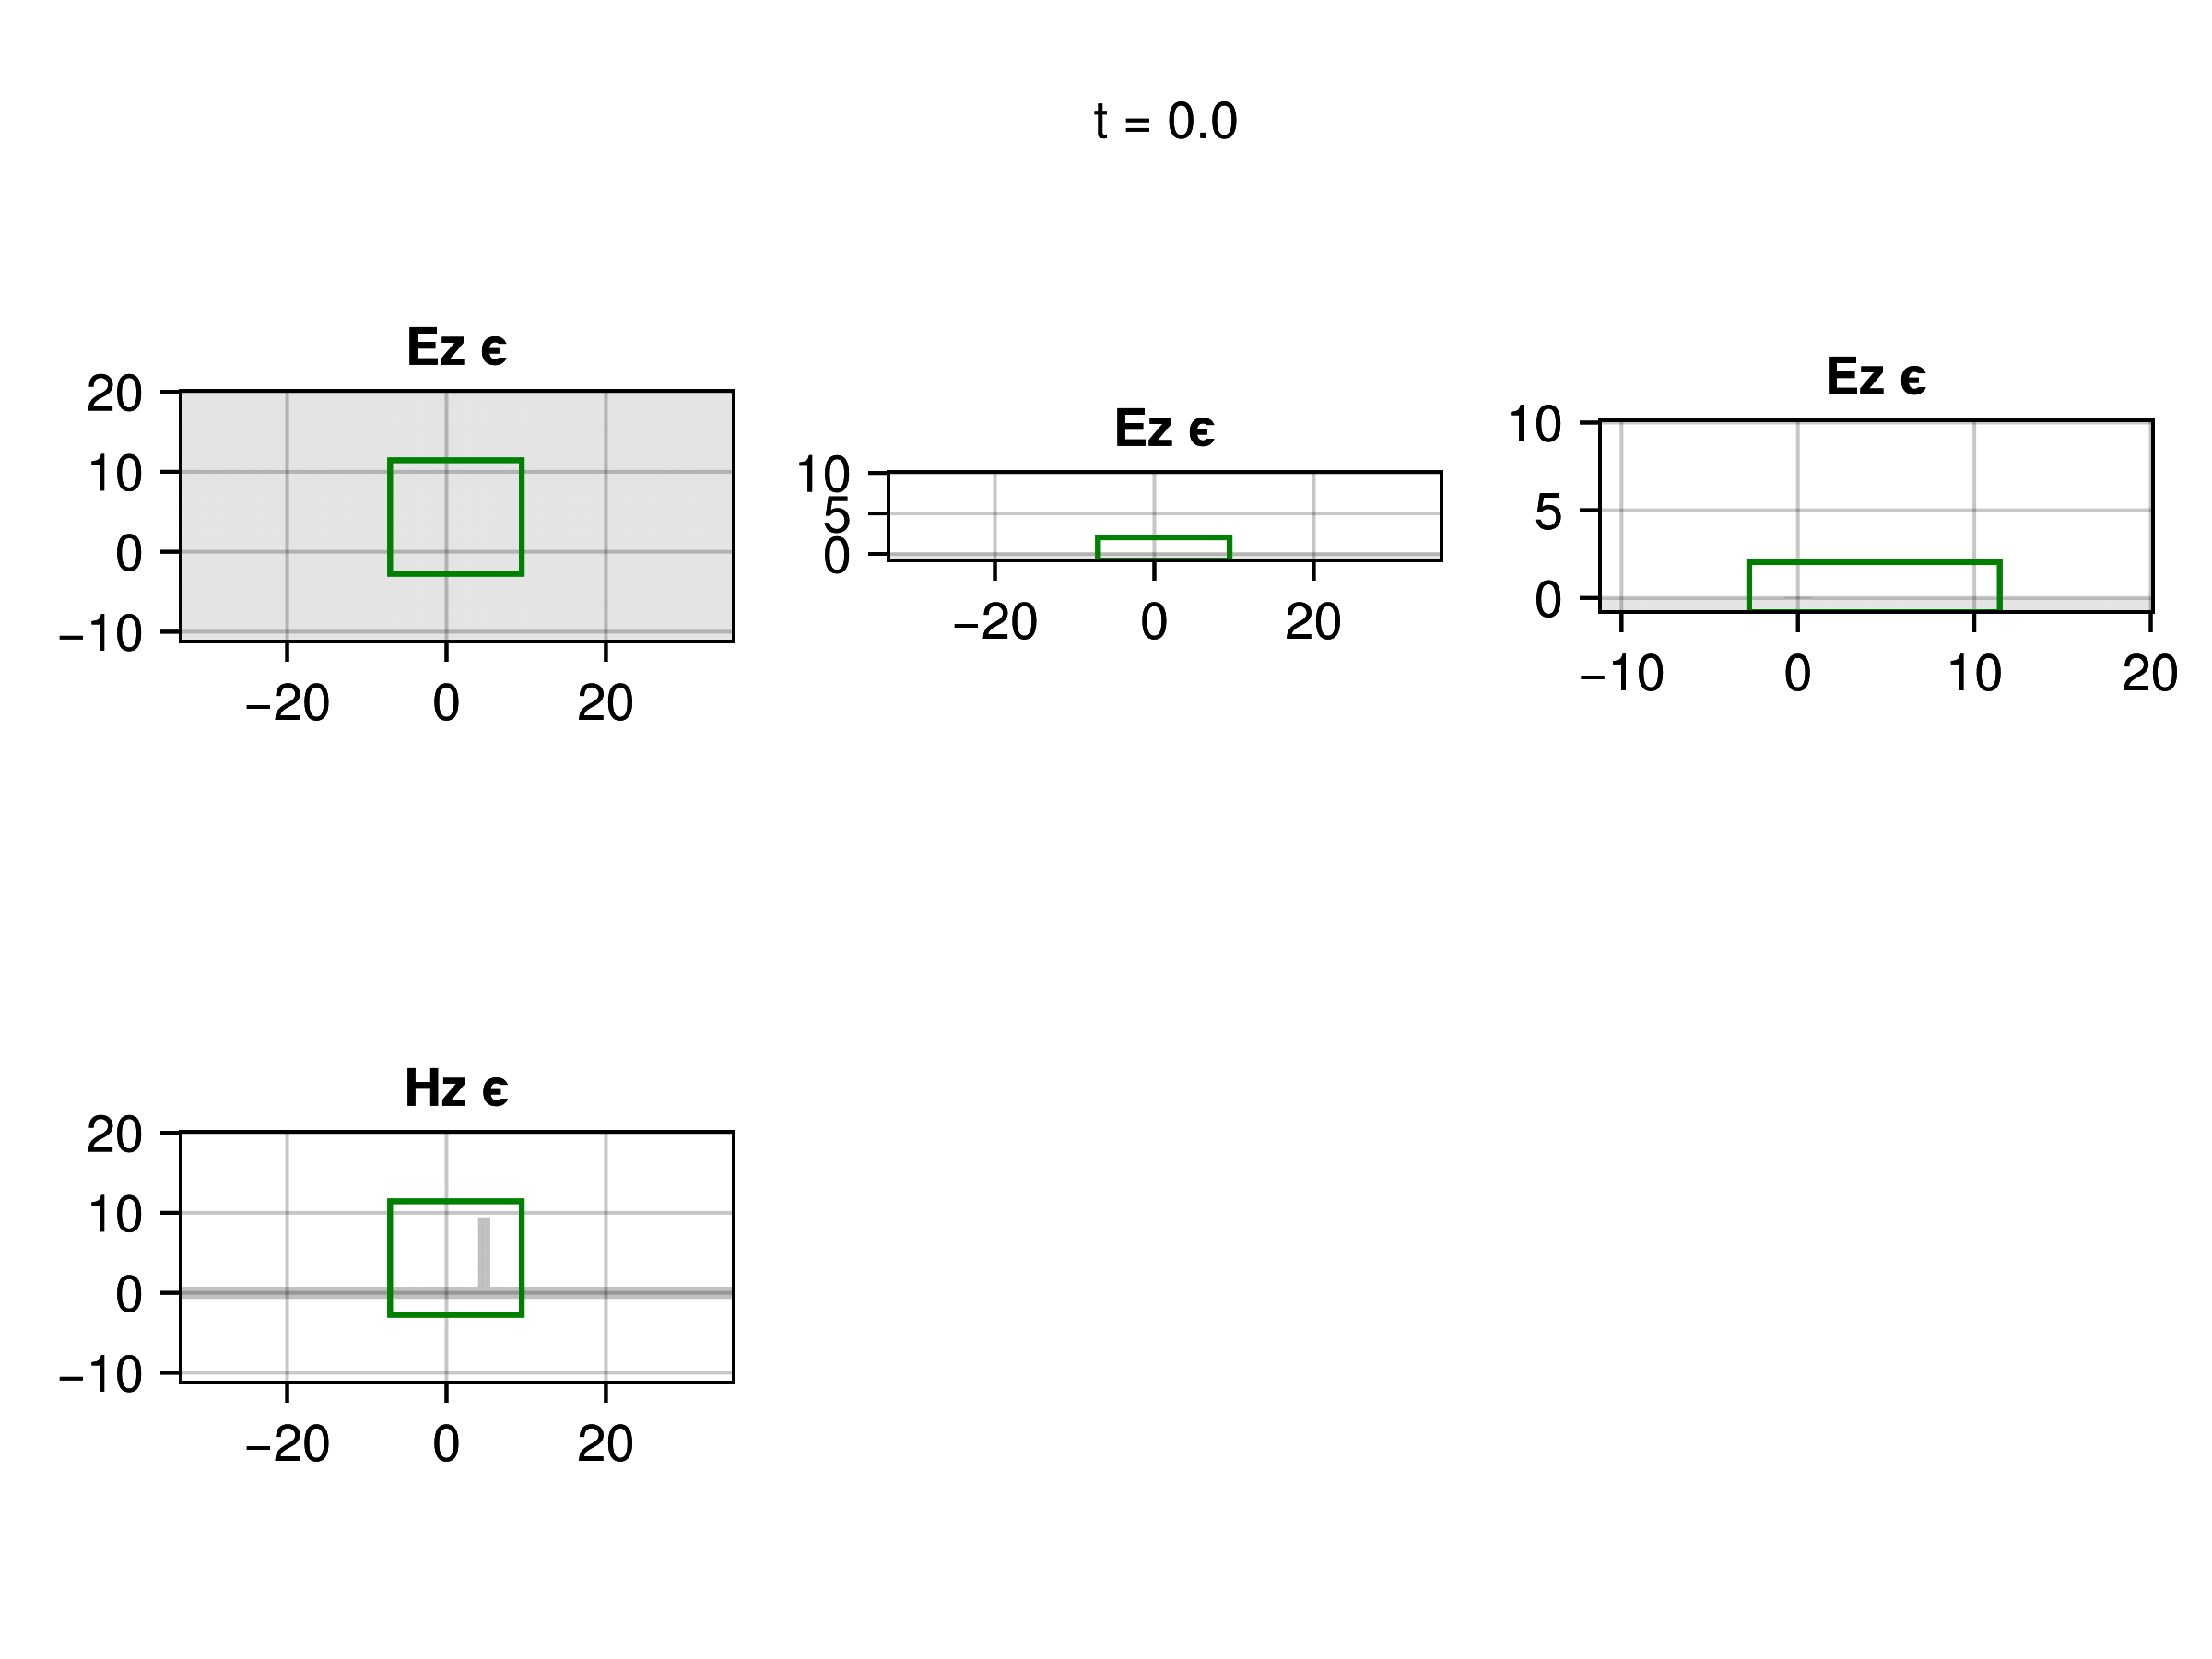

In [ ]:
lumi.movie(path)

## Analysis

loading solution from /home/weihu/luminescent_community_cluster/paul@luminescentai.com/microstrip_stub_filter
may take a minute if simulation folder is remotely mounted


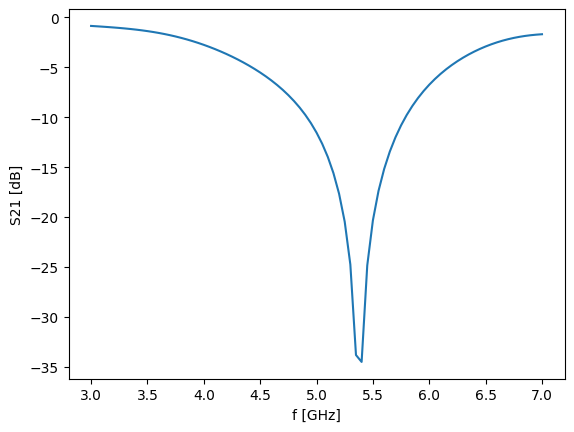

In [ ]:
sol = lumi.load(path)
x = frequencies
y = lumi.query(sol, "To2,o1") # convenience function for T-parameters using modal decomposition

# S-parameters can also be computed explicitly from complex valued modal or voltage waves:
# y = np.abs2(sol["waves"]["o2@0+"] / sol["waves"]["o1@0-"]) # explicit T21 using forward/backward modal amplitudes
# y = np.abs2(sol["waves"]["o2+"] / sol["waves"]["o1-"]) # using forward/backward voltage waves

y = [10 * np.log10(v) for v in y]
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()

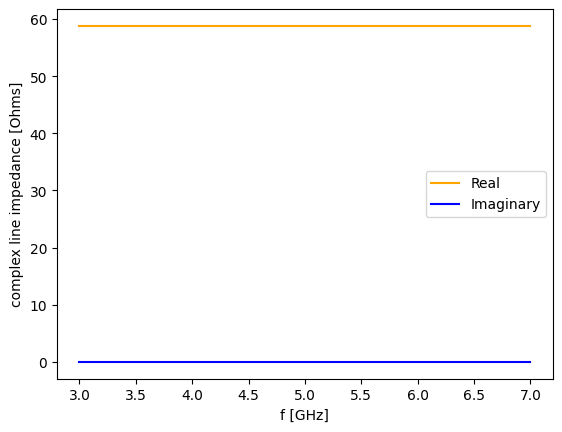

In [ ]:
y=377*sol['Z']['o1']
plt.plot(x,np.real(y),label="Real",color='orange')
plt.plot(x,np.imag(y),label="Imaginary",color='blue')
plt.xlabel("f [GHz]")
plt.ylabel('complex line impedance [Ohms]')
plt.legend()
plt.show()